# Data Analysis functionalities

This notebook showcases analytic and data manipulation concepts related to trend forecasting with respect to boarder crossings and cargo shift data sets via Duck DB SQL and Python.

## 0. Install the virtual environment

Step 1: _Install the virtual environment:_  
pip install virtualenv  

Step 2: _Associate the latest python version:_  
virtualenv myenv --python=python3  

Step 3: _Activate the virtual environment: On Windows_  
myenv\Scripts\activate  

Step 4: _Install necessary packages:_  
pip install duckdb sktime statsforecast skforecast tqdm pandas matplotlib numpy datetime seaborn sklearn warnings logging typing itertools statsmodels  

Step 5: _Install Jupyter Notebook:_  
pip install jupyter  

Step 6: _Create the folder (replace 'path/to/your/folder' with your desired folder path):_  
mkdir path/to/your/folder  

Step 7: _Change directory to the created folder:  
cd path/to/your/folder  

Step 8: _Launch Jupyter Notebook:_  
jupyter notebook

In [ ]:
!pip install pandoc
!winget install Pandoc
!pdflatex --version
!pip install --upgrade pandoc
!Pandoc --version

In [3]:
!where Pandoc

C:\Users\balan\anaconda3\Scripts\pandoc.exe
C:\Users\balan\AppData\Local\Pandoc\pandoc.exe


In [ ]:
!xelatex --version
!mpm --admin --update-db
!mpm --admin --list
!mpm --admin --install=xetex

In [1]:
#!jupyter nbconvert --to pdf CargoDataSet_Analysis.ipynb --PDFExporter.latex_command="xelatex"
!jupyter nbconvert --to pdf --debug CargoDataSet_Analysis.ipynb

[NbConvertApp] Searching ['C:\\Users\\balan\\anaconda3\\etc\\jupyter', 'C:\\Users\\balan\\.jupyter', 'C:\\Users\\balan\\AppData\\Roaming\\Python\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\balan\AppData\Roaming\Python\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\balan\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\balan\anaconda3\etc\jupyter
[NbConvertApp] Loaded config file: C:\Users\balan\anaconda3\etc\jupyter\jupyter_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\balan\AppData\Roaming\Python\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\balan\.jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\balan\anaconda3\etc\jupyter
[NbConvertApp] Converting notebook

## 1. Pip install section

In [7]:
pip install duckdb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install statsforecast

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install skforecast

In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


## 2. SQL data preparation section (DuckDB) - Boarder Crossings Data Set

In [388]:
# import section
import duckdb
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import time
from sktime.split import ExpandingWindowSplitter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import sklearn.model_selection
# from sklearn.metrics import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid, StratifiedKFold
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from typing import Union, Callable, Optional, Tuple
import sktime
# from sktime.forecasting.sarimax import SARIMAXForecaster
import warnings
import logging
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [11]:
# SQL-Queries:
#-----------------------
# query 1: import the entire csv file into a new DB table "AllData":
""" 
Alternative with json file:
CREATE TABLE IF NOT EXISTS new_tbl AS
SELECT *
FROM read_json_auto('input.json')
"""
query1 = """
    CREATE TABLE IF NOT EXISTS AllData AS
    SELECT * FROM read_csv('Border_Crossing_Entry_Data.csv')
    """
# Select the first 7 columns of the AllData table and store them into a new table "RelevantData"
query2 = """
    CREATE TABLE IF NOT EXISTS RelevantData AS
    SELECT #1, #2, #3, #4, #5, #6, #7 
    FROM AllData
    """ 

# Select the first 7 columns of the "RelevantData" table and store them into a new table "US_Canada_Data"
query3 = """
    CREATE TABLE IF NOT EXISTS US_Canada_Data AS
    SELECT #1, #2, #3, #4, #5, #6, #7 
    FROM RelevantData
    WHERE Border = 'US-Canada Border'
    """ 

# Select the first 7 columns of the "RelevantData" table and store them into a new table "US_Mexico_Data"
query4 = """
    CREATE TABLE IF NOT EXISTS US_Mexico_Data AS
    SELECT #1, #2, #3, #4, #5, #6, #7 
    FROM RelevantData
    WHERE Border = 'US-Mexico Border'
    """ 
# Describe the schema of the US_Canada_Data table
query5 = "DESCRIBE US_Canada_Data"

# Convert a string date column to date format with a CTE
query6 = """
CREATE TABLE IF NOT EXISTS US_Canada_Data_Altered AS
SELECT 
    *,
    strptime(concat('01 ', Date), '%d %b %Y') AS converted_date
FROM 
    US_Canada_Data
"""

# Select the entire altered table US_Canada_Data_Altered
query7 = "SELECT * FROM US_Canada_Data_Altered"

# Describe the altered table US_Canada_Data_Altered
query8 = "DESCRIBE US_Canada_Data_Altered"

# Order the table US_Canada_Data_Altered based on the converted_date
# column in ascending manner
query9 = """
SELECT *
FROM US_Canada_Data_Altered
ORDER BY converted_date ASC
"""

# Ctreate a US_Canada_AggregatedData table
query10 = """
-- Step 1: Drop the table if it exists
DROP TABLE IF EXISTS US_Canada_AggregatedData;

-- Step 2: Create the new table and populate it with aggregated data
CREATE TABLE IF NOT EXISTS US_Canada_AggregatedData AS
SELECT 
    converted_date, 
    AVG(Value) AS avg_value_month, 
    SUM(Value) AS total_value_month
FROM 
    US_Canada_Data_Altered
GROUP BY 
    converted_date
ORDER BY 
    converted_date ASC;
"""

# select the aggregated table:
query11 = """
SELECT *
FROM US_Canada_AggregatedData
"""

In [26]:
# Connect to DuckDB and use the SQL-queries:
with duckdb.connect("Border.duckdb") as db:
    # select the entire Border table
    allData_table = db.sql(query1)
    
    # display table data
    allData_tablePart = db.sql("SELECT * FROM AllData LIMIT 10")
    print("The first 10 entries of the AllData table: \n", allData_tablePart)

    #-------------------------

    # Select the relevant part of the data and store them into a new table "RelevantData"
    relevantData_table = db.sql(query2)

    # display table data of "RelevantData"
    relevantData_tablePart = db.sql("SELECT * FROM RelevantData LIMIT 10")
    print("The first 10 entries of the RelevantData table: \n", relevantData_tablePart)

    #-------------------------

    # Select the relevant part of the data and store them into a new table "US_Canada_Data"
    US_Canada_Data_table = db.sql(query3)

    # display table data of "US_Canada_Data"
    US_Canada_Data_tablePart = db.sql("SELECT * FROM US_Canada_Data LIMIT 10")
    print("The first 10 entries of the US_Canada_Data table: \n", US_Canada_Data_tablePart)

    #-------------------------

    # Select the relevant part of the data and store them into a new table "US_Mexico_Data"
    US_Mexico_Data_table = db.sql(query4)

    # display table data of "US_Mexico_Data"
    US_Mexico_Data_tablePart = db.sql("SELECT * FROM US_Mexico_Data LIMIT 10")
    print("The first 10 entries of the US_Mexico_Data table: \n", US_Mexico_Data_tablePart)

    #-------------------------

    # display the US_Canada_Data table
    print("Describe the US-Canada table:\n")
    db.sql(query5).show()

    #-------------------------

    # extract the date time format from a date string column
    db.sql(query6)
    ConvertedDate = db.sql(query7)
    print("Date time column: ", ConvertedDate)

    # display the US_Canada_Data_Altered table
    print("Describe the US_Canada_Data_Altered table:\n")
    db.sql(query8).show()

    # Order the table US_Canada_Data_Altered based on the converted_date
    # column in ascending manner
    print("Date time ordered US_Canada_Data_Altered table:\n")
    db.sql(query9).show()

    # Ctreate a US_Canada_AggregatedData table (averaged per month)
    print("Average aggregated US_Canada_Data_Altered table:\n")
    db.sql(query10)

    print("The aggregated time stamp ordered US_Canada_AggregatedData table:\n")
    db.sql(query11).show()

    #-------------------------

    # display current tables within the duck db:
    print("Current tables in the Border.duckdb database:\n")
    db.sql("SHOW TABLES").show()
    
    #-------------------------

    # store all three curated tables into corresponding pandas DataFrames

    relevantData_df = db.sql("SELECT * FROM RelevantData").df()
    US_Canada_Data_df = db.sql("SELECT * FROM US_Canada_Data").df()
    US_Mexico_Data_df = db.sql("SELECT * FROM US_Mexico_Data").df()
    US_Canada_Data_Aggregated_df = db.sql("SELECT * FROM US_Canada_AggregatedData").df()

    #-------------------------
    
    # disconnect from the database
    print("Closing the data base...\n")
    db.close()

    #-------------------------
    
    # display the DataFrames

    print("First ten entries of the relevantData_df:\n")
    print(relevantData_df.head(10))

    print("First ten entries of the US_Canada_Data_df:\n")
    print(US_Canada_Data_df.head(10))

    print("First ten entries of the US_Mexico_Data_df:\n")
    print(US_Mexico_Data_df.head(10))

    print("First ten entries of the US_Canada_AggregatedData_df:\n")
    print(US_Canada_Data_Aggregated_df.head(10))

The first 10 entries of the AllData table: 
 ┌──────────────┬───────────┬───────────┬──────────────────┬──────────┬─────────────────────────────┬────────┬──────────┬───────────┬────────────────────────────────────────────┐
│  Port Name   │   State   │ Port Code │      Border      │   Date   │           Measure           │ Value  │ Latitude │ Longitude │                   Point                    │
│   varchar    │  varchar  │  varchar  │     varchar      │ varchar  │           varchar           │ int64  │  double  │  double   │                  varchar                   │
├──────────────┼───────────┼───────────┼──────────────────┼──────────┼─────────────────────────────┼────────┼──────────┼───────────┼────────────────────────────────────────────┤
│ Jackman      │ Maine     │ 0104      │ US-Canada Border │ Jan 2024 │ Trucks                      │   6556 │   45.806 │   -70.397 │ POINT (-70.396722 45.805661)               │
│ Porthill     │ Idaho     │ 3308      │ US-Canada Border │ Apr 2

## 3. Useful python functions for time series analysis

### 3.1 ARIMA vs Regression - Explanations

The choice between ARIMA (AutoRegressive Integrated Moving Average) and regression models depends heavily on the structure and characteristics of the data as well as the specific requirements of the prediction problem. Here are some guidelines on when to use which method:

*__ARIMA__* 

ARIMA models are particularly useful when:

Time series structure: the data have a clear time series structure, i.e. the observations are in evenly spaced time intervals.

Stationarity: The data tends to be stationary or can be made stationary by differentiation. Stationary time series have constant mean values and variances over time.

Autocorrelation: There is a strong autocorrelation in the data, i.e. past values are strongly correlated with future values.

No exogenous variables: There are no external explanatory variables that influence the time series. ARIMA models are based exclusively on the historical values of the time series itself.

*__Regression__* 

Regression models are particularly useful when:

Prediction by influencing variables: You want to predict the future values of a target variable based on one or more exogenous variables (influencing variables).

No strong time structure: There is no strong time series structure or the time component is less important than the explanatory variables.

Multivariate analysis: You want to consider several explanatory variables simultaneously in order to predict the target variable.

Interactions and effects: You want to analyze the effects and interactions between different explanatory variables.

*__An example to illustrate:__* 

ARIMA: You want to predict the future sales figures of a product based on past sales figures without taking other external influencing variables into account.

Regression: You want to predict future sales figures based on several influencing variables such as price changes, advertising campaigns, seasonal effects and economic data.

The choice of model therefore depends heavily on the data and the specific use case. In practice, it can be useful to try out and compare different models in order to achieve the best forecasting accuracy.

### 3.2 Parameter grid search 1 - customized cross validation functions

#### 3.2.1 SARIMAX customized functionality

In [490]:
def estimate_period(time_series, max_period=15):
    """
    Estimate the period of a given time series using FFT and cap it at a maximum value.

    Parameters:
    time_series (list or numpy array): The input time series data.
    max_period (int): The maximum period value to cap the estimated period.

    Returns:
    int: The capped period of the time series.
    """
    # Convert the time series to a numpy array
    time_series = np.array(time_series)

    # Remove the mean of the time series to focus on the frequency component
    time_series = time_series - np.mean(time_series)

    # Compute the FFT of the time series
    fft_result = np.fft.fft(time_series)

    # Compute the power spectrum
    power_spectrum = np.abs(fft_result)**2

    # Find the index of the dominant frequency (excluding the zero frequency component)
    dominant_frequency_index = np.argmax(power_spectrum[1:]) + 1

    # Compute the sample frequency
    sample_frequency = np.fft.fftfreq(len(time_series))

    # Compute the period corresponding to the dominant frequency
    dominant_frequency = sample_frequency[dominant_frequency_index]
    period = int(np.abs(1 / dominant_frequency))

    # Display the real estimated period
    print(f"Real Estimated Period: {period}")

    # Cap the period at the maximum value
    if period > max_period:
        period = max_period
        print(f"Capped Period: {period}")
    else:
        print(f"Period (No Capping Needed): {period}")

    return period

def splitInputData(x):
    """
    INPUTS:
    x: a list of train data values
    
    OUTPUTS:
    TrainData, TestData: data partitions (each being a list of 6 Pandas Series)
    
    EXPLANATION:
    The function performs a tree-fold separation 
    of x into a train data partition (66 %, TrainData) and 
    a validation data partition (33 %, TestData)
    """
    TrainData = []
    TestData = []

    DataPart1 = x[: int(len(x)//3)]
    DataPart2 = x[int(len(x)//3)+1:2*int(len(x)//3)]
    DataPart3 = x[2*int(len(x)//3)+1: len(x)]

    Case1_train = DataPart1 + DataPart2
    Case1_test = DataPart3

    Case2_train = DataPart1 + DataPart3
    Case2_test = DataPart2

    Case3_train = DataPart2 + DataPart3
    Case3_test = DataPart1

    Case4_train = DataPart2 + DataPart1
    Case4_test = DataPart3

    Case5_train = DataPart3 + DataPart1
    Case5_test = DataPart2

    Case6_train = DataPart3 + DataPart2
    Case6_test = DataPart1

    TrainData = [pd.Series(Case1_train), pd.Series(Case2_train), pd.Series(Case3_train), 
                 pd.Series(Case4_train), pd.Series(Case5_train), pd.Series(Case6_train)]
    TestData = [pd.Series(Case1_test), pd.Series(Case2_test), pd.Series(Case3_test), 
                pd.Series(Case4_test), pd.Series(Case5_test), pd.Series(Case6_test)]
    
    return TrainData, TestData
    
def SARIMAX_grid_search(x, seasonal_param = 12):
    """
    INPUTS:
    x: a list of train data values
    seasonal_param: an integer, 12 (default) for monthly, 
                    7 for weekly time periods, etc.
    
    OUTPUTS:
    best_params: a tuple of optimal six 
    SARIMAX-parameters with respect to x
    
    EXPLANATION:
    The function performs a SARIMAX 
    grid search with respect to x
    """
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import itertools
    from joblib import Parallel, delayed
    
    # Creating the hyperparameter grid
    p_values = [2, 3, 4, 5]
    d_values = range(1, 5)
    q_values = range(1, 3)
    P_values = [2]
    D_values = [2]
    Q_values = [2]
    s_values = [seasonal_param]

    param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))
    
    # Split input data
    TrainData, TestData = splitInputData(x)

    def evaluate_sarimax(params):
        rmse_values_temp = []
        for trains, tests in zip(TrainData, TestData):
            try:
                model = SARIMAX(trains, order=(params[0], params[1], params[2]), 
                                seasonal_order=(params[3], params[4], params[5], params[6]))
                model_fit = model.fit(disp=False)
                y_pred = model_fit.get_forecast(steps=len(tests))
                y_pred_df = y_pred.conf_int(alpha=0.05)
                y_pred_df["Predictions"] = model_fit.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
                y_pred_out = y_pred_df["Predictions"]
                sarimax_rmse = np.sqrt(mean_squared_error(tests, y_pred_out))
                rmse_values_temp.append(sarimax_rmse)
            except Exception as e:
                print(f"Error for parameters {params}: {e}")
                rmse_values_temp.append(np.inf)  # Assign a high error value for failed parameter sets
        return np.mean(rmse_values_temp), params

    # Use Parallel processing for faster grid search
    results = Parallel(n_jobs=-1)(delayed(evaluate_sarimax)(params) for params in param_grid)

    # Find the best parameters
    best_rmse, best_params = min(results, key=lambda x: x[0])
    
    print(f"Tuned SARIMAX Parameters: {best_params}")
    print(f"Best average rmse score is {best_rmse}")

     # Evaluate the best model on the test data
    best_model = SARIMAX(TrainData[0], order=(best_params[0], best_params[1], best_params[2]), 
                         seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]))
    best_model_fit = best_model.fit(disp=False)
    y_pred = best_model_fit.get_forecast(steps=len(TestData[0]))
    y_pred_df = pd.DataFrame(y_pred.conf_int(alpha=0.05))
    y_pred_df["Predictions"] = best_model_fit.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    y_pred_out = y_pred_df["Predictions"]

    # Calculate confidence intervals
    y_pred_conf_int = y_pred.conf_int(alpha=0.05)

    # Display tabulated predictions
    PredictedData = pd.DataFrame()
    PredictedData['Time Period'] = TestData[0].index
    PredictedData['True Values'] = TestData[0].values
    PredictedData['Predicted Values'] = y_pred_out.values
    PredictedData['Confidence Lower'] = y_pred_conf_int.iloc[:, 0].values
    PredictedData['Confidence Upper'] = y_pred_conf_int.iloc[:, 1].values
    
    print(PredictedData.head(10))

    print("-----------------------------\n")

    return best_params

def PlotBestParameterSarimaxFit(train, test, best_params):
    """
    INPUTS:
    train: a list of train data values
    test: a list of test data values
    best_params: a tuple of optimal six 
    SARIMAX-parameters with respect to x
    
    OUTPUTS:
    a plot of test, train and forecasted data with respect
    to a particular time interval
    
    EXPLANATION:
    The function plots the optimal prediction of a SARIMAX 
    grid search with respect to train and test data sets
    and their corresponding time intervals
    """
    best_param_dict = dict()
    best_params_keys = ['p', 'd', 'q', 'P', 'D', 'Q', 's']
    
    for iter in range(7):
        best_param_dict[best_params_keys[iter]] = best_params[iter]
    
    print(best_param_dict)
    
    SARIMAXmodel = SARIMAX(train, order=(best_param_dict['p'], best_param_dict['d'], best_param_dict['q']),
                           seasonal_order=(best_param_dict['P'], best_param_dict['D'], best_param_dict['Q'], best_param_dict['s']))
    SARIMAXmodel = SARIMAXmodel.fit()
    y_pred = SARIMAXmodel.get_forecast(len(test))
    y_pred_df = pd.DataFrame(y_pred.conf_int(alpha=0.05))
    # print(y_pred_df)
    y_pred_df["Predictions"] = SARIMAXmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
    # y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]
    
    months_all = [(month + 1) for month in range(len(test))]
    plt.plot(months_all, y_pred_out, color='Blue', label='SARIMA Predictions')
    
    sarimax_rmse = np.sqrt(mean_squared_error(test, y_pred_df["Predictions"]))
    print("RMSE: ", sarimax_rmse)
    
    months_all = [(month + 1) for month in range(len(test))]
    plt.plot(months_all, test, color="black", label='Original test data')
    plt.ylabel('Measure Value')
    plt.xlabel('Time Period')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    print("-----------------------------\n")

def AutomatedSarimaxGridSearch(train_ds, test_ds, seasonal_period=12, batch_size=10000):
    """
    INPUTS:
    train_ds: a Pandas Series of train data values
    test_ds:  a Pandas Series of test data values
    seasonal_period: an integer, 12 (default) for monthly, 
                     7 for weekly time periods, etc.
    batch_size: the size of each batch for processing
    
    OUTPUTS:
    a plot of test, train and forecasted data with respect
    to a particular time interval + statistics of
    predicted results
    
    EXPLANATION:
    The function displays results of the optimal 
    prediction of an Auto-SARIMAX grid search with respect 
    to the train data set and its corresponding 
    time intervals;
    The function also: 
    1) plots the optimal prediction of a Auto-SARIMAX 
    grid search with respect to train and test data sets
    (Pandas Series) and their corresponding time intervals
    2) displays a statistics table of predicted results
    (Pandas DataFrame)
    """
    from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
    from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
    from sktime.forecasting.base import ForecastingHorizon
    from sktime.performance_metrics.forecasting import mean_squared_error
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Function to split data into batches
    def split_into_batches(data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

    # Split train_ds into batches
    train_batches = list(split_into_batches(train_ds, batch_size))

    best_params_list = []
    best_score_list = []
    
    for batch in train_batches:
        # Use expanding window splitter on each batch
        splt = ExpandingWindowSplitter(fh=[1, 2, 3])
        
        # Using StatsForecastAutoARIMA
        model = StatsForecastAutoARIMA(
            sp=seasonal_period,  # seasonal period
            seasonal=True
        )

        # Define the parameter grid
        param_grid = {
            'start_p': [1, 2],
            'start_q': [1, 2],
            'max_p': [4],
            'max_q': [4],
            'd': [1, 2]
        }

        # Create the grid search object
        grid_search = ForecastingGridSearchCV(
            forecaster=model,
            param_grid=param_grid,
            cv=splt,
            n_jobs=-1 #,
            # scoring=mean_squared_error  # custom scoring metric, default Mean Average Error
        )
        
        # Fit the grid search
        grid_search.fit(batch)
        
        # Get best parameters and score for each batch
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        best_params_list.append(best_params)
        best_score_list.append(best_score)
        
        print(f"Batch Best parameters: {best_params}")
        print(f"Batch Best score: {best_score}")

    # Select the best parameters and score from all batches
    best_overall_index = np.argmin(best_score_list)
    best_overall_params = best_params_list[best_overall_index]
    best_overall_score = best_score_list[best_overall_index]
    
    print(f"Overall Best parameters: {best_overall_params}")
    print(f"Overall Best score: {best_overall_score}")
    
    # Fit the final model with the best overall parameters
    best_forecaster = StatsForecastAutoARIMA(
        sp=seasonal_period,
        seasonal=True,
        **best_overall_params
    )
    
    best_forecaster.fit(train_ds)
    
    # Define the forecasting horizon
    fh = ForecastingHorizon(test_ds.index, is_relative=False)
    
    # Get predictions from the best forecaster
    y_pred = best_forecaster.predict(fh)
    
    # Manually compute the confidence intervals
    pred_std = np.std(y_pred) * 1.96  # Approximate 95% confidence interval
    conf_int_lower = y_pred - pred_std
    conf_int_upper = y_pred + pred_std

    # Plot the actual and predicted values
    months_test = [(month+1) for month in range(len(train_ds), len(train_ds)+len(test_ds))]
    plt.figure(figsize=(12, 6))
    plt.plot(train_ds.index, train_ds, label='Train Data')
    plt.plot(months_test, test_ds, label='Test Data', color='orange')
    plt.plot(months_test, y_pred, label='Best Forecast', color='green')
    plt.fill_between(months_test, conf_int_lower, conf_int_upper, color='gray', alpha=0.2, label='95% Confidence Interval')
    plt.legend(bbox_to_anchor=(0.75, 1.15), ncol=4)
    plt.title('Forecast vs Actuals')
    plt.xlabel('Time Period')
    plt.ylabel('Values')
    plt.show()
    
    # Display tabulated predictions
    PredictedData = pd.DataFrame()
    PredictedData['Time Period'] = test_ds.index
    PredictedData['Predicted Values'] = y_pred.values
    PredictedData['Confidence Lower'] = conf_int_lower.values
    PredictedData['Confidence Upper'] = conf_int_upper.values
    
    print(PredictedData.head(10))

    print("-----------------------------\n")

    return best_overall_params
 
# Example usage
# Assuming train_ds and test_ds have been defined
# AutomatedSarimaxGridSearch(train_ds, test_ds)

#### 3.2.2 Linear Regression functionality

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def regressionsanalyse_mit_plot(datensatz, zielvariable):
    """
    Führt eine lineare Regressionsanalyse auf einem gegebenen Datensatz durch und plottet die Ergebnisse.

    Args:
    - datensatz (pd.DataFrame): Der Datensatz, der die Eingangsvariablen und die Zielvariable enthält.
    - zielvariable (str): Der Name der Zielvariable (Spalte) im Datensatz.

    Returns:
    - dict: Ein Wörterbuch mit den Ergebnissen der Regressionsanalyse.
    """
    # Eingangsvariablen und Zielvariable trennen
    X = datensatz.drop(columns=[zielvariable])
    y = datensatz[zielvariable]

    # Datensatz in Trainings- und Testdaten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Lineares Regressionsmodell erstellen und trainieren
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Vorhersagen auf den Testdaten
    y_pred = model.predict(X_test)

    # Berechnung der Metriken
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Ergebnisse plotten
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Vorhersagen')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
    plt.xlabel('Tatsächliche Werte')
    plt.ylabel('Vorhergesagte Werte')
    plt.title('Tatsächliche vs. vorhergesagte Werte')
    plt.legend()
    plt.show()

    # Ergebnisse zusammenstellen
    ergebnisse = {
        'Modell': model,
        'Mean Squared Error (MSE)': mse,
        'R^2 Score': r2,
        'Koefizienten': model.coef_,
        'Intercept': model.intercept_,
        'Vorhersagen': y_pred,
        'Testdaten': y_test
    }

    return ergebnisse

# Beispielverwendung
# Angenommen, datensatz ist ein Pandas DataFrame und 'Zielvariable' ist der Name der Zielspalte
# datensatz = pd.read_csv('dein_datensatz.csv')
# ergebnisse = regressionsanalyse_mit_plot(datensatz, 'Zielvariable')
# print(ergebnisse)

### 3.3 Parameter grid search 1 - Example: a US-Canada Boarder Crossings Data Set

#### 3.3.1 Data preparation - Date time stamp preprocessing

In [74]:
# Date time stamp preprocessing
DateStrings = US_Canada_Data_df['Date']
print(DateStrings)
type(DateStrings)

0         Jan 2024
1         Apr 2024
2         Jan 2024
3         Jan 2024
4         Jan 2024
            ...   
304059    Dec 2024
304060    Dec 2024
304061    Dec 2024
304062    Dec 2024
304063    Dec 2024
Name: Date, Length: 304064, dtype: object


pandas.core.series.Series

In [76]:
DateTypes = pd.to_datetime(DateStrings)
DateTypes = DateTypes.apply(lambda x: x.strftime('%m-%Y'))
DateTypes.columns = ['DateTime']
print(DateTypes)
type(DateTypes[0])

0         01-2024
1         04-2024
2         01-2024
3         01-2024
4         01-2024
           ...   
304059    12-2024
304060    12-2024
304061    12-2024
304062    12-2024
304063    12-2024
Name: Date, Length: 304064, dtype: object


str

In [78]:
Month = DateTypes.apply(lambda x: int(x[:2]))
Month.columns = ['Month']
print(Month)

0          1
1          4
2          1
3          1
4          1
          ..
304059    12
304060    12
304061    12
304062    12
304063    12
Name: Date, Length: 304064, dtype: int64


In [81]:
Year = DateTypes.apply(lambda x: int(x[3:7]))
Year.columns = ['Year']
print(Year)

0         2024
1         2024
2         2024
3         2024
4         2024
          ... 
304059    2024
304060    2024
304061    2024
304062    2024
304063    2024
Name: Date, Length: 304064, dtype: int64


#### 3.3.2 Data preparation - Data Frame preprocessing and sorting

In [83]:
US_Canada_Data_df['Month'] = Month
US_Canada_Data_df['Year'] = Year
US_Canada_Data_df = US_Canada_Data_df.sort_values(by=['Month', 'Year'], axis=0, ascending=True)
print(US_Canada_Data_df)

            Port Name       State Port Code            Border      Date  \
3328           Scobey     Montana      3309  US-Canada Border  Jan 1996   
232905      Limestone       Maine      0118  US-Canada Border  Jan 1996   
278457        Skagway      Alaska      3103  US-Canada Border  Jan 1996   
278480      Madawaska       Maine      0109  US-Canada Border  Jan 1996   
278618         Blaine  Washington      3004  US-Canada Border  Jan 1996   
...               ...         ...       ...               ...       ...   
304059         Roseau   Minnesota      3426  US-Canada Border  Dec 2024   
304060  Point Roberts  Washington      3017  US-Canada Border  Dec 2024   
304061         Opheim     Montana      3317  US-Canada Border  Dec 2024   
304062      Van Buren       Maine      0108  US-Canada Border  Dec 2024   
304063          Ferry  Washington      3013  US-Canada Border  Dec 2024   

                       Measure  Value  Month  Year  
3328                    Trains      0      1  

In [87]:
UniqueMonths = Month.unique()
print(np.sort(UniqueMonths))

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [89]:
UniqueYears = Year.unique()
print(np.sort(UniqueYears))

[1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]


In [91]:
US_Canada_Data_df.describe()

,Value,Month,Year
count,3.040640e+05,304064.000000,304064.000000
mean,9.990897e+03,6.483004,2008.690674
std,6.350075e+04,3.446599,7.750888
min,0.000000e+00,1.000000,1996.000000
25%,0.000000e+00,3.000000,2002.000000
50%,8.400000e+01,6.000000,2008.000000
75%,1.487000e+03,9.000000,2015.000000
max,2.523598e+06,12.000000,2024.000000


#### 3.3.3 Data preparation - Data Frame aggregation

In [95]:
AggregateDictionary = dict()
for iterYear in UniqueYears:
    MeasuresYear = []
    for iterMonth in UniqueMonths:
        condition1 = US_Canada_Data_df['Year'] == iterYear
        condition2 = US_Canada_Data_df['Month'] == iterMonth
        Temp_df = US_Canada_Data_df[condition1 & condition2]
        MeasuresYear.append(Temp_df['Value'].sum())
        AggregateDictionary[iterYear] = MeasuresYear

# sort dictionary according to its keys
myKeys = list(AggregateDictionary.keys())
myKeys.sort()

# Sorted Dictionary
sd = {i: AggregateDictionary[i] for i in myKeys}
AggregateDictionary = sd
print(AggregateDictionary)

{1996: [9492824, 11771390, 9971650, 10795053, 17988012, 13306955, 14737836, 10801524, 10819163, 12785097, 13788034, 16781365], 1997: [9436325, 10277874, 9533652, 11213563, 16834126, 12645355, 13397632, 10014597, 10903931, 12086771, 13345769, 15823115], 1998: [9509603, 11408750, 9606589, 10622465, 15867936, 12321480, 12780630, 9776730, 10270735, 11607099, 12836779, 15682994], 1999: [8963032, 10827952, 9515913, 10607585, 16408819, 14126950, 13600774, 10157514, 10842100, 12209136, 13211576, 16025977], 2000: [9120445, 11872809, 9417181, 11557273, 16509750, 13035044, 13653957, 9766290, 10567692, 12196150, 13369583, 16723499], 2001: [9968711, 10463283, 8803012, 10788933, 15909159, 11449120, 12655972, 7919578, 8136859, 8656311, 9942374, 15399079], 2002: [7967046, 9458774, 7839425, 9484491, 14371954, 10487686, 11102595, 8780240, 8850342, 10238366, 10848047, 13403729], 2003: [8186226, 7766297, 7549888, 8578623, 12952628, 9168311, 10273715, 8167744, 8295872, 9499606, 9959044, 12340460], 2004: [7

In [97]:
AggregateDF = pd.DataFrame.from_dict(AggregateDictionary)
print(AggregateDF)

        1996      1997      1998      1999      2000      2001      2002  \
0    9492824   9436325   9509603   8963032   9120445   9968711   7967046   
1   11771390  10277874  11408750  10827952  11872809  10463283   9458774   
2    9971650   9533652   9606589   9515913   9417181   8803012   7839425   
3   10795053  11213563  10622465  10607585  11557273  10788933   9484491   
4   17988012  16834126  15867936  16408819  16509750  15909159  14371954   
5   13306955  12645355  12321480  14126950  13035044  11449120  10487686   
6   14737836  13397632  12780630  13600774  13653957  12655972  11102595   
7   10801524  10014597   9776730  10157514   9766290   7919578   8780240   
8   10819163  10903931  10270735  10842100  10567692   8136859   8850342   
9   12785097  12086771  11607099  12209136  12196150   8656311  10238366   
10  13788034  13345769  12836779  13211576  13369583   9942374  10848047   
11  16781365  15823115  15682994  16025977  16723499  15399079  13403729   

        200

#### 3.3.4 Data preparation - Plotting Section

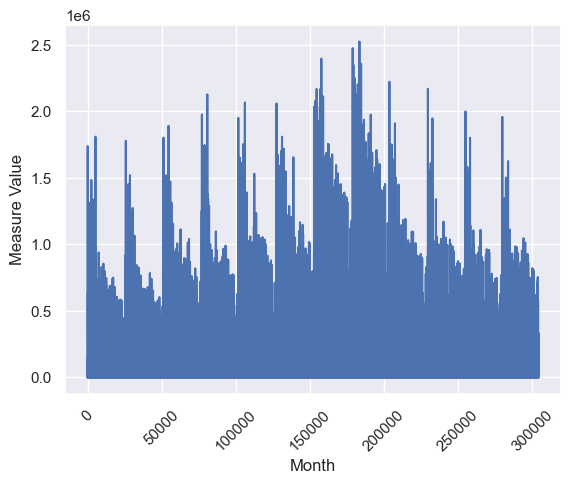

In [103]:
# Data Frame plot
sns.set()
plt.ylabel('Measure Value')
plt.xlabel('Month')
plt.xticks(rotation=45)
months = [(month+1) for month in range(len(US_Canada_Data_df['Value']))]
plt.plot(months, US_Canada_Data_df['Value'],'-')
plt.show()

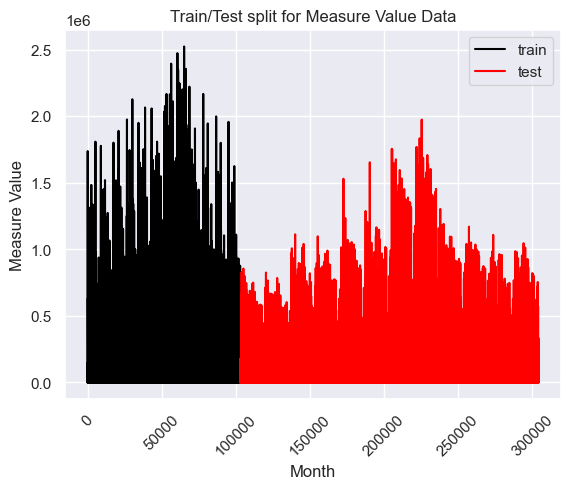

In [109]:
# train-test split plot of a DataFrame
train = US_Canada_Data_df[US_Canada_Data_df['Year'] < 2005]['Value']
test = US_Canada_Data_df[US_Canada_Data_df['Year'] >= 2005]['Value']

months1 = [(month+1) for month in range(len(train))]
months2 = [(month+1) for month in range(len(train),len(train)+len(test))]

plt.plot(months1,train, color = "black")
plt.plot(months2,test, color = "red")
plt.ylabel('Measure Value')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.title("Train/Test split for Measure Value Data")
plt.legend(['train', 'test'])
plt.show()

In [111]:
y = train.values
print(y)

[    0    13     0 ... 18222     0     0]


#### 3.3.4 Data analysis - Analysis of aggregated data

In [119]:
# create a list of aggregated data that are to be analyzed
AggregateList = []
for key in AggregateDictionary.keys():
    AggregateList.append(AggregateDictionary[key])

DataSet = list(itertools.chain.from_iterable(AggregateList))
print(DataSet)

[9492824, 11771390, 9971650, 10795053, 17988012, 13306955, 14737836, 10801524, 10819163, 12785097, 13788034, 16781365, 9436325, 10277874, 9533652, 11213563, 16834126, 12645355, 13397632, 10014597, 10903931, 12086771, 13345769, 15823115, 9509603, 11408750, 9606589, 10622465, 15867936, 12321480, 12780630, 9776730, 10270735, 11607099, 12836779, 15682994, 8963032, 10827952, 9515913, 10607585, 16408819, 14126950, 13600774, 10157514, 10842100, 12209136, 13211576, 16025977, 9120445, 11872809, 9417181, 11557273, 16509750, 13035044, 13653957, 9766290, 10567692, 12196150, 13369583, 16723499, 9968711, 10463283, 8803012, 10788933, 15909159, 11449120, 12655972, 7919578, 8136859, 8656311, 9942374, 15399079, 7967046, 9458774, 7839425, 9484491, 14371954, 10487686, 11102595, 8780240, 8850342, 10238366, 10848047, 13403729, 8186226, 7766297, 7549888, 8578623, 12952628, 9168311, 10273715, 8167744, 8295872, 9499606, 9959044, 12340460, 7373490, 8626328, 7821507, 8799951, 12960841, 9669448, 10525294, 8023030

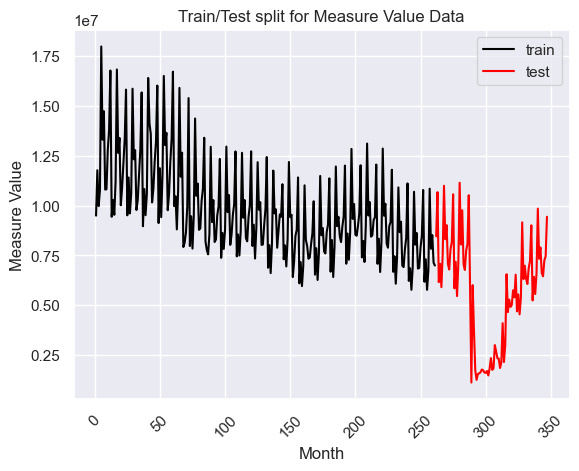

In [505]:
# create data set lists for training and testing
train = DataSet[:int(0.75*len(DataSet))]
test = DataSet[int(0.75*len(DataSet))+1:]

months1 = [(month+1) for month in range(len(train))]
months2 = [(month+1) for month in range(len(train),len(train)+len(test))]

plt.plot(months1,train, color = "black")
plt.plot(months2,test, color = "red")
plt.ylabel('Measure Value')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.title("Train/Test split for Measure Value Data")
plt.legend(['train', 'test'])
plt.show()

In [503]:
# view the train data set
y = train
print(y)

0       10268.277
70      10154.000
86      10449.046
161     11541.317
210     11530.548
          ...    
4382     8477.620
4401     8784.182
4436    10012.271
4494     9504.726
4521     9612.634
Name: TotalMetricTons, Length: 114, dtype: float64


In [495]:
# start the grid search
start_time = time.time()
best_params = SARIMAX_grid_search(y, 12)
print("--- Duration: %s seconds ---" % (time.time() - start_time))

Tuned SARIMAX Parameters: (2, 1, 2, 2, 2, 2, 12)
Best average rmse score is 3622051.7420007405
   Time Period  True Values  Predicted Values  Confidence Lower  \
0            0      7690676      7.876369e+06      4.669138e+06   
1            1      7594110      7.503923e+06      4.259713e+06   
2            2      8669030      7.609453e+06      4.243794e+06   
3            3      9048099      8.223683e+06      4.826908e+06   
4            4     11366681      8.724421e+06      5.278799e+06   
5            5      6677975      1.023144e+07      6.749724e+06   
6            6      8265991      6.450796e+06      2.929420e+06   
7            7      6409080      8.117489e+06      4.558953e+06   
8            8      7938922      6.341962e+06      2.745789e+06   
9            9     11961504      7.836648e+06      4.203646e+06   

   Confidence Upper  
0      1.108360e+07  
1      1.074813e+07  
2      1.097511e+07  
3      1.162046e+07  
4      1.217004e+07  
5      1.371316e+07  
6      9.9721

In [497]:
# print the optimal grid search parameters
print(best_params)

(2, 1, 2, 2, 2, 2, 12)


In [507]:
# specify test data
test = DataSet[int(0.75*len(DataSet))+1:]
print(test)

[8454019, 10673299, 6151874, 7073413, 5901475, 7561801, 10993925, 8307472, 9015529, 7070154, 6788073, 7813441, 8172138, 10564665, 5841881, 7175976, 5451377, 7098470, 11146471, 8039300, 9762713, 7058135, 6763885, 7733413, 8070939, 10519310, 5895552, 1110625, 6000979, 3703717, 1714174, 1242037, 1540712, 1568631, 1624869, 1762684, 1730368, 1612690, 1596316, 1688595, 1465675, 1818274, 2333125, 1748625, 1825042, 2989342, 2674041, 2327083, 2312496, 1838438, 2126121, 4091393, 2140893, 2992770, 6550339, 4648165, 5273546, 4908379, 4999946, 5741597, 5388875, 6527388, 4685610, 5534787, 4536450, 5373629, 9156150, 6305656, 6978141, 6324285, 6059394, 6855550, 7226765, 9007752, 5235491, 6420099, 5553414, 6615667, 9846338, 7327974, 7896159, 6610310, 6446254, 7246849, 7448569, 9437171]


{'p': 2, 'd': 1, 'q': 2, 'P': 2, 'D': 2, 'Q': 2, 's': 12}
RMSE:  8225957.22264755


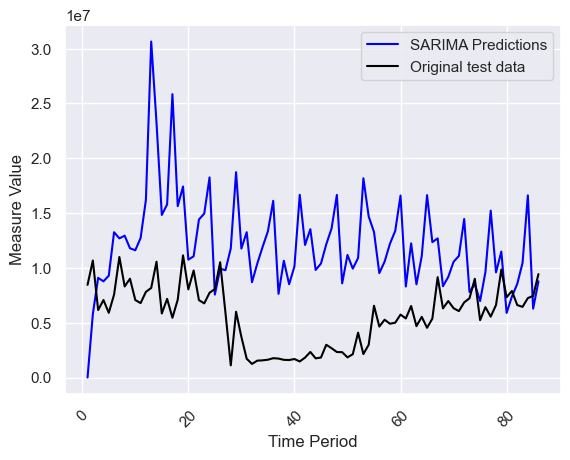

In [509]:
# plot optimal predictions of the time searies analysis
PlotBestParameterSarimaxFit(train, test, best_params)

### 3.4 Parameter grid search 2 - Automated cross-validation with SARIMAX grid_search_sarimax

In [241]:
# sample definition of a parameter grid
# Creating the hyperparameter grid
# Define the parameter grids
p_values = [2, 3, 4, 5]
d_values = range(1, 5)
q_values = range(1, 3)
P_values = [2]
D_values = [2]
Q_values = [2]
s_values = [12]

param_grid_Sarimax = list(itertools.product(p_values, d_values, q_values))
print(param_grid_Sarimax)
param_grid_total = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

[(2, 1, 1), (2, 1, 2), (2, 2, 1), (2, 2, 2), (2, 3, 1), (2, 3, 2), (2, 4, 1), (2, 4, 2), (3, 1, 1), (3, 1, 2), (3, 2, 1), (3, 2, 2), (3, 3, 1), (3, 3, 2), (3, 4, 1), (3, 4, 2), (4, 1, 1), (4, 1, 2), (4, 2, 1), (4, 2, 2), (4, 3, 1), (4, 3, 2), (4, 4, 1), (4, 4, 2), (5, 1, 1), (5, 1, 2), (5, 2, 1), (5, 2, 2), (5, 3, 1), (5, 3, 2), (5, 4, 1), (5, 4, 2)]


In [261]:
# generate pandas Series from our data set lists
train_ds = pd.Series(DataSet[:int(0.75*len(DataSet))])
test_ds = pd.Series(DataSet[int(0.75*len(DataSet))+1:])

Best parameters: {'d': 1, 'max_p': 4, 'max_q': 4, 'start_p': 2, 'start_q': 1}
Best score: 0.058513277865117716

All results:
   mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                               0.058784       0.573899        0.004614   
1                               0.058712       0.547104        0.004619   
2                               0.058513       0.424519        0.004580   
3                               0.058513       0.525039        0.004665   
4                               0.068219       0.640988        0.004662   
5                               0.068929       0.796791        0.004417   
6                               0.068957       0.957988        0.004389   
7                               0.068293       0.992713        0.004392   

                                              params  \
0  {'d': 1, 'max_p': 4, 'max_q': 4, 'start_p': 1,...   
1  {'d': 1, 'max_p': 4, 'max_q': 4, 'start_p': 1,...   
2  {'d': 1, 'max_p': 4, 'max_q'

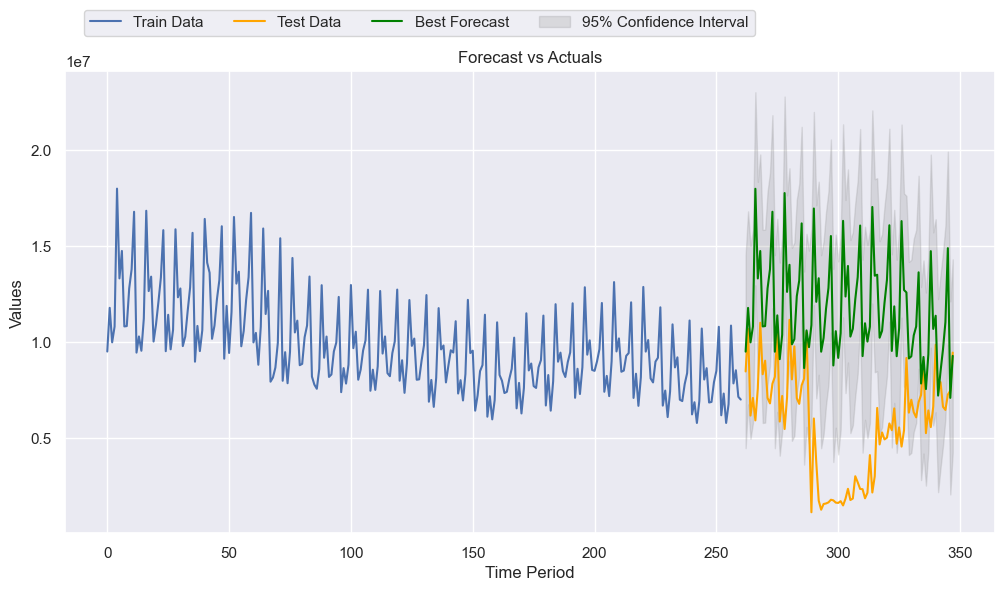

   Time Period  Predicted Values  Confidence Lower  Confidence Upper
0            0      9.487343e+06      4.452919e+06      1.452177e+07
1            1      1.176717e+07      6.732749e+06      1.680160e+07
2            2      9.970411e+06      4.935986e+06      1.500484e+07
3            3      1.079340e+07      5.758979e+06      1.582783e+07
4            4      1.798019e+07      1.294577e+07      2.301461e+07
5            5      1.330475e+07      8.270328e+06      1.833918e+07
6            6      1.473462e+07      9.700193e+06      1.976904e+07
7            7      1.080241e+07      5.767983e+06      1.583683e+07
8            8      1.081993e+07      5.785507e+06      1.585436e+07
9            9      1.278392e+07      7.749494e+06      1.781834e+07
--- Duration: 260.2104489803314 seconds ---


In [263]:
# perform an auto-SARIMAX frid search
start_time = time.time()
AutomatedSarimaxGridSearch(train_ds, test_ds, 12)
print("--- Duration: %s seconds ---" % (time.time() - start_time))